In [1]:
import os

import numpy as np
import pandas as pd

from deephyper.skopt.learning import RandomForestRegressor

from sklearn.preprocessing import QuantileTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
exp_dir = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/polaris/dhb/output/"
# exp_name = "dhb_combo-DBOS4MSHA-async-RF-qUCB-qUCB-128-4-10800-42-decay-0.1"
exp_name = "dhb_combo-DBOS4MSHA-async-RF-qUCB-qUCB-128-4-10800-42-identity"
exp_file = os.path.join(exp_dir, exp_name, "results.csv")

In [3]:
df = pd.read_csv(exp_file)

In [4]:
df

,p:activation,p:base_lr,p:batch_normalization,p:batch_size,p:dense_0,p:dense_1,p:dense_2,p:dense_feature_layers_0,p:dense_feature_layers_1,p:dense_feature_layers_2,...,objective,job_id,rank,budget,timestamp_submit,timestamp_gather,timestamp_start,timestamp_end,pruned,num_parameters
0,relu,0.000444,False,148,80,14,82,248,137,492,...,-0.381229,0,0,1,1.972056,31.621775,2.531530,31.620641,True,1510809
1,hard_sigmoid,0.001426,True,384,13,312,13,89,439,18,...,-0.746031,0,217,1,1.640893,27.378289,1.727564,27.377720,True,529713
2,relu,0.000369,False,390,599,10,15,60,73,259,...,-0.407805,0,205,1,1.325052,27.408036,1.334579,27.406864,True,806421
3,sigmoid,0.000024,False,387,108,47,87,15,26,377,...,-1.000000,0,448,1,2.461040,27.441736,3.625504,27.441201,True,224578
4,sigmoid,0.000014,True,479,112,45,285,21,515,90,...,-1.000000,0,451,1,1.790069,27.606280,1.885821,27.605792,True,264816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58084,hard_sigmoid,0.004454,False,10,533,27,37,36,78,439,...,-0.000207,165,447,1,10690.612035,10768.341572,10690.623522,10768.340701,True,965308
58085,softplus,0.000250,True,478,256,290,483,22,514,490,...,-0.007067,83,177,1,10733.999186,10768.455354,10734.009113,10768.454592,True,1225713
58086,selu,0.003064,False,27,813,194,830,23,126,1013,...,-0.512172,169,70,1,10717.131491,10768.586926,10717.144371,10768.584757,True,3165476
58087,gelu,0.001764,False,52,614,347,38,201,789,469,...,0.895305,48,439,50,10170.394497,10768.834156,10170.410537,10768.832950,False,3112339


In [5]:
# Prepare categorical variables
categorical_variables = [vname for vname in df.columns if "p:" in vname and df.dtypes[vname] == np.object_]
categorical_variables_encoding = "label"

print(categorical_variables)

# onehot
if categorical_variables_encoding == "onehot":
    print("onehot")
    df = pd.get_dummies(df, columns=categorical_variables)
elif categorical_variables_encoding == "label":
    print("label")
    for vname in categorical_variables:
        df[vname] = pd.Categorical(df[vname]).codes

['p:activation', 'p:loss', 'p:optimizer', 'p:scaling']
label


In [6]:
# Prepare boolean variables
bool_variables = [vname for vname in df.columns if "p:" in vname and df.dtypes[vname] == np.bool_]
df = df.astype({vname:np.int64 for vname in bool_variables})

In [7]:
# Prepare real variables
float_variables = [vname for vname in df.columns if "p:" in vname and df.dtypes[vname] == np.float_]
for vname in float_variables:
#     scaler = QuantileTransformer(output_distribution="normal")
#     scaler = PowerTransformer()
#     df[vname] = scaler.fit_transform(df.loc[:, vname].values.reshape(-1, 1))
    pass

In [8]:
# Prepare target variables for minimization (real behaviour of deephyper.skopt)
df["objective"] = df["objective"]

In [10]:
# Prepare sample weights
sample_weight = (df["budget"].values) / 50
sample_weight

array([0.02, 0.02, 0.02, ..., 0.02, 1.  , 0.02])

In [42]:
variables = [vname for vname in df.columns if "p:" in vname]
X = df.loc[:, variables].values
X = np.concatenate([X, df["budget"].values.reshape(-1, 1)], axis=1)
y = -df["objective"].values

In [43]:
from deephyper.skopt.utils import cook_objective_scaler

In [44]:
# # Define possible transformations for output variable
# eps = 1e-3
# scalers_y = {}

# # clip-log
# def transform_clip_log(X):
#     X = np.clip(-X, 0, 1)
#     X = np.log(1-X+eps)
#     return X
    
# def inv_transform_clip_log(X):
#     X = 1-(np.exp(X)-eps)
#     return -X

# scaler_clip_log = FunctionTransformer(
#     func=transform_clip_log,
#     inverse_func=inv_transform_clip_log,
#     check_inverse=False
# )
# scalers_y["clip:log"] = scaler_clip_log

# # min-max
# def transform_log(X):
#     X = np.log(X+eps)
#     return X
    
# def inv_transform_log(X):
#     X = np.exp(X)-eps
#     return X

# scaler_log = FunctionTransformer(
#     func=transform_log,
#     inverse_func=inv_transform_log,
#     check_inverse=True
# )
# scaler_min_max = make_pipeline(
#     MinMaxScaler(), scaler_log
# )
# scalers_y["minmax:log"] = scaler_min_max

# # identity
# scaler_identity = FunctionTransformer(
#     func=lambda x: x,
#     inverse_func=lambda x: x
# )
# scalers_y["identity"] = scaler_identity

In [45]:
# y_preprocessing = "minmax:log"
y_preprocessing = "identity"
scaler_y = cook_objective_scaler(y_preprocessing, RandomForestRegressor())
print(scaler_y)

# scaler_y = scalers_y[y_preprocessing]
y = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)

ratio = 0.8
num_samples = int(len(X)*ratio)
X_train = X[:num_samples]
y_train = y[:num_samples]
X_test = X[num_samples:]
y_test = y[num_samples:]
sample_weight_train = sample_weight[:num_samples]
sample_weight_test = sample_weight[num_samples:]
print(f"#training {num_samples}")
print(f"#testing  {len(y_test)}")

select_fully_trained = (~df.pruned).values[num_samples:]

print(f"#selected: {select_fully_trained.astype(int).sum()}")

FunctionTransformer(func=<function cook_objective_scaler.<locals>.<lambda> at 0x2a7fab280>,
                    inverse_func=<function cook_objective_scaler.<locals>.<lambda> at 0x2a7fab310>)
#training 46471
#testing  11618
#selected: 361


In [46]:
est = RandomForestRegressor(n_jobs=8)
est.fit(X_train, y_train)
# est.fit(X_train, y_train, sample_weight=sample_weight_train)

r2_train = est.score(X_train, y_train)
r2_test_all = est.score(X_test, y_test)
r2_test_fully_trained = est.score(X_test[select_fully_trained], y_test[select_fully_trained])

print(f"Transformed target space [{y_preprocessing}]")
print(f"{r2_train=:.3f} - {r2_test_all=:.3f} - {r2_test_fully_trained=:.3f}")

Transformed target space [identity]
r2_train=0.987 - r2_test_all=0.941 - r2_test_fully_trained=0.779


In [47]:
y_pred = est.predict(X_test)
y_true = y_test

y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1))

print(f"Preprocessing: {y_preprocessing}")
print("Full target space")
print("All futur data")
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"{r2=:.3f} - {mse=:.3f} - {mae=:.3f}\n")

print("Fully trained future data")
r2 = r2_score(y_true[select_fully_trained], y_pred[select_fully_trained])
mse = mean_squared_error(y_true[select_fully_trained], y_pred[select_fully_trained])
mae = mean_absolute_error(y_true[select_fully_trained], y_pred[select_fully_trained])
print(f"{r2=:.3f} - {mse=:.3f} - {mae=:.3f}")

Preprocessing: identity
Full target space
All futur data
r2=0.941 - mse=0.032 - mae=0.106

Fully trained future data
r2=0.779 - mse=0.003 - mae=0.017


In [48]:
for x0, x1 in zip(y_pred[select_fully_trained].reshape(-1).tolist(), y_true[select_fully_trained].reshape(-1).tolist()):
    print(f"{-x0:.2f} - {-x1:.2f}")

0.90 - 0.91
0.91 - 0.91
0.90 - 0.90
0.90 - 0.91
0.90 - 0.91
0.90 - 0.91
0.89 - 0.90
0.91 - 0.90
0.79 - 0.89
0.91 - 0.91
0.90 - 0.90
0.90 - 0.90
0.90 - 0.89
0.90 - 0.90
0.90 - 0.90
0.90 - 0.91
0.84 - 0.90
0.90 - 0.91
0.91 - 0.91
0.90 - 0.91
0.90 - 0.90
0.90 - 0.90
0.88 - 0.91
0.90 - 0.91
0.90 - 0.90
0.90 - 0.90
0.90 - 0.90
0.91 - 0.89
0.90 - 0.91
0.90 - 0.90
0.90 - 0.90
0.90 - 0.91
0.90 - 0.90
0.88 - 0.90
0.87 - 0.90
0.90 - 0.90
0.91 - 0.91
0.90 - 0.91
0.90 - 0.91
0.90 - 0.90
0.90 - 0.91
0.68 - 0.39
0.90 - 0.90
0.90 - 0.91
0.90 - 0.91
0.90 - 0.91
0.91 - 0.92
0.90 - 0.90
0.90 - 0.91
0.90 - 0.91
0.89 - 0.91
0.90 - 0.91
0.90 - 0.91
0.91 - 0.91
0.90 - 0.90
0.85 - 0.87
0.90 - 0.90
0.90 - 0.90
0.90 - 0.91
0.91 - 0.91
0.90 - 0.91
0.91 - 0.90
0.90 - 0.91
0.91 - 0.91
0.90 - 0.90
0.90 - 0.90
0.90 - 0.91
0.91 - 0.91
0.90 - 0.91
0.89 - 0.90
0.90 - 0.91
0.90 - 0.91
0.90 - 0.91
0.90 - 0.90
0.91 - 0.91
0.90 - 0.91
0.90 - 0.91
0.91 - 0.89
0.90 - 0.91
0.90 - 0.90
0.84 - 0.90
0.90 - 0.90
0.89 - 0.90
0.83

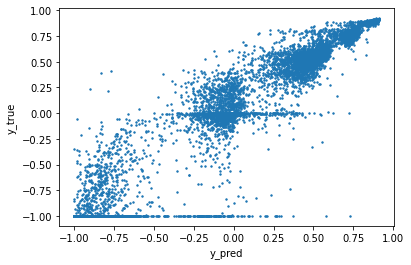

In [49]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(-y_pred.reshape(-1), -y_true.reshape(-1), s=2)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [58]:
x = X[0].reshape(1, -1)
x[-1] = 50
est.predict(x)

array([-0.07753618])

In [53]:
x

array([[4.00000000e+00, 4.44065813e-04, 0.00000000e+00, 1.48000000e+02,
        8.00000000e+01, 1.40000000e+01, 8.20000000e+01, 2.48000000e+02,
        1.37000000e+02, 4.92000000e+02, 3.57189220e-01, 1.00000000e+00,
        1.40000000e+01, 1.86977660e-05, 3.00000000e+00, 3.00000000e+00,
        0.00000000e+00, 3.83438473e-01, 1.30000000e+01, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [57]:
list(df.columns).index("budget")

25